# A Text Mining Approach to Analyze The Cyber Security Related Articles

## PART-3: Text Mining

__Feature Engineering with NLP techniques__


__Importing of Required Libraries__

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import pickle
import re

import spacy
import en_core_web_sm
from spacy import displacy

import string
import random
from num2words import num2words

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

__Loading Data__

As mentioned Part-2 that pandas parquet options doesn't support timedelta type. So we need to use __fastparquet__ option, to keep the timedelta type format.

In [2]:
df_sum=pd.read_parquet('data/df_sum_parquet.gzip',engine='fastparquet')
df_investigator_cyber=pd.read_parquet('data/df_investigator_cyber_parque.gzip',engine='fastparquet')
df_sum.head(2)

,AwardID,AwardTitle,AwardEffectiveDate,AwardExpirationDate,AwardAmount,ProgramOfficer,Institution_Name,Institution_StateName,Abstract,Year,Award_Duration,AwardAmount_Million,Abstract_Lenght
0,0110599,Collaborative Research Testing Affect Control ...,2001-08-15,2004-07-31,300000.0,Patricia White,University of Arizona,Arizona,The investigators will conduct a series of exp...,2001,1081 days,0.30,2194
1,0112426,Federal Cyber Service Initiative,2001-06-01,2007-06-30,149995.0,Timothy V. Fossum,University of Tulsa,Oklahoma,This program produces a cadre of computer scie...,2001,2220 days,0.15,765


## A-) Clustering and Topic Modeling

In [3]:
#Create a new DataFrame
df_sum2=df_sum[['AwardID','AwardTitle','Abstract']]
df_sum2.head(2)

,AwardID,AwardTitle,Abstract
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a series of exp...
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...


__Replacing Of Contraction Words__

In [4]:
replacement_patterns = {
    r"won\'t": "will not",
    r"can\'t": "cannot",
    r"i\'m": "i am",
    r"ain\'t": "is not",
    r"(\w+)\'ll": "\g<1> will",
    r"(\w+)n\'t": "\g<1> not",
    r"(\w+)\'ve": "\g<1> have",
    r"(\w+)\'s": "\g<1> is",
    r"(\w+)\'re": "\g<1> are",
    r"(\w+)\'d": "\g<1> would",
    r"&": "and",
    r"<br/>":""}

df_sum2['Abstract'].replace(replacement_patterns, regex=True, inplace=True)
df_sum2.head(2)

,AwardID,AwardTitle,Abstract
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a series of exp...
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...


__Removing Unneccesery Words__

We use __NER__ (Named Entity Recognition) function of __spacy__ library to detect named entities (people, places, organizations, dates, times etc.) from the text. After analyzing this words, we understood that they are unnecessary for clustering.

An example of visualization of NER:

In [5]:
#define the nlp object
nlp = en_core_web_sm.load()

#example text
doc=nlp(str(df_sum2['Abstract'][1]))

#visualization
displacy.render(doc, style="ent",jupyter=True)

In [6]:
#create a list for NER
NER_list=[]

#Find
for n in range(df_sum2.shape[0]):
    doc=nlp(str(df_sum2['Abstract'][n]))

    for ent in doc.ents:
        NER_list.append(ent.text)

NER_list = [' {0} '.format(elem) for elem in NER_list] #Add space to begins and ends of all NERs to prevent the 
print('Total NER words: {}'.format(len(NER_list)))
NER_list=list(set(NER_list)) #for unique elements in list
print('Total unique NER words: {}'.format(len(NER_list)))

print('Total words before removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

for NER in NER_list:
    df_sum2['Abstract']=df_sum2['Abstract'].str.replace(NER,' ',regex=False) #regex=False>> because, some NERs have punctuation
print('Total words after removing NER: {}'.format(sum(df_sum2['Abstract'].str.len())))

Total NER words: 64069
Total unique NER words: 18654
Total words before removing NER: 11239471
Total words after removing NER: 10494262


__Tokenization and LowerCase__

In [7]:
#word tokenization and lowercase
df_sum2['Abstract_Tokens'] = df_sum2['Abstract'].str.lower().apply(nltk.word_tokenize)
print('Total words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words: 1650870


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[the, investigators, will, conduct, a, of, exp..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Numbers__

In [8]:
#remove numbers
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in df_sum2['Abstract_Tokens'][n] if w.isalpha()]
print('Total words consist of only alphabets: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words consist of only alphabets: 1426331


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[the, investigators, will, conduct, a, of, exp..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Written Form of Numbers__

In [9]:
#Create a list about numbers in written form
num2words_list=[]

for n in range(100):
    num=num2words(n)
    num2words_list.append(num)
    num_ord=num2words(n, ordinal=True) #we use num2words library
    num2words_list.append(num_ord) #we use num2words library
num2words_list=[n.replace('-','') for n in num2words_list]#remove the "-" punctuation

for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in df_sum2['Abstract_Tokens'][n] if w not in num2words_list]
print('Total words after removing written form of numbers: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing written form of numbers: 1425794


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[the, investigators, will, conduct, a, of, exp..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[this, program, produces, a, cadre, of, comput..."


__Remove Stopwords__

In [10]:
#define stopwords list
stopwords_list=nltk.corpus.stopwords.words('english')

#extend the stopwords list
stopwords_list.extend(['cannot','many','much','also','well','better','via','able','could','able','whether',
                      'either','unfortunately','far','new','high'])

#extend the stopwords list with unneccessary words for this study
stopwords_list.extend(['abstract','program','pi'])


for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in df_sum2['Abstract_Tokens'][n] if w not in stopwords_list]
print('Total words after removing stopwords: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing stopwords: 834114


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigators, conduct, experiments, focus, c..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produces, cadre, computer, scientists, strong..."


__Lemmatization with POS Tag__

In [11]:
#define lemmatizer() object
lemmatizer = WordNetLemmatizer()

#lemmatize with POS Tag
def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)


for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[lemmatizer.lemmatize(w,get_wordnet_pos(w)) for w in df_sum2['Abstract_Tokens'][n]]

print('Total words after lemmatization: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after lemmatization: 834114


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ..."


__Remove 1-Length Words__

Punctuation
Punctuation are the unnecessary symbols that are in our corpus documents,

In [12]:
#remove 1-len words
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in df_sum2['Abstract_Tokens'][n] if len(w)>=2]
print('Total words after removing 1-len words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing 1-len words: 833259


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ..."


__Remove Meaningless Words__

We can try to create a 'English Wordlist' from nltk with __nltk.corpus.words.words()__ method. But this wordlist has 236736 words. In this list some important words like 'internet', 'online', 'monitoring', 'firewall', 'crypto' etc.

In this study, we prefer to use a comprehensive wordlist from a [github account](https://github.com/dwyl/english-words) which has 370104 words. But still, we need to add some critical words to list like 'cyberinfrastructure','cybersecurity' etc. So we extended the our wordlist with __IT cyber terms__ list. The list created from open-source (different websites) manualy.

In [13]:
#Scrape a wordlist
url='https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt'
data = pd.read_csv(url,  header=None)
wordlist=list(data[0].values)
print('Total words in wordlist from corpus: {}'.format(len(wordlist)))

#extend the wordlist with IT_terms
df_IT_terms=pd.read_csv('data/IT_cyber_terms.csv', sep=';')
IT_terms_list=list(df_IT_terms['Words'])
wordlist.extend(IT_terms_list) #extend the wordlist
wordlist=list(set(wordlist)) #remove the duplications
print('Total words in wordlist after adding IT terms: {}'.format(len(wordlist)))

#Check the tokens from wordlist
for n in range(df_sum2.shape[0]):
    df_sum2['Abstract_Tokens'][n]=[w for w in  df_sum2['Abstract_Tokens'][n] if w in wordlist]
print('Total words after removing the meaningless words: {}'.format(sum(df_sum2['Abstract_Tokens'].str.len())))
df_sum2.head(2)

Total words after removing the meaningless words: 811985


,AwardID,AwardTitle,Abstract,Abstract_Tokens
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru..."
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ..."


__Convert Tokens To String For Tf-idf Vectorize__

In [15]:
df_sum2['Tokens_String']=df_sum2['Abstract']
for n in range(df_sum2.shape[0]):
    df_sum2['Tokens_String'][n]=' '.join([str(item) for item in df_sum2['Abstract_Tokens'][n]])
df_sum2.head(2)

,AwardID,AwardTitle,Abstract,Abstract_Tokens,Tokens_String
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru...",investigator conduct experiment focus crucial ...
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong specia...


__TfidfVectorizer__

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer()
X = v.fit_transform(df_sum2['Tokens_String'])
X.toarray()[:2]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
print('First 10 Feature Name:\n {}'.format(v.get_feature_names()[:10]))

First 10 Feature Name:
 ['aa', 'aaa', 'ab', 'abandonment', 'abdomen', 'aberrant', 'abet', 'abide', 'ability', 'abiotic']


In [18]:
print('Total Feature Number: {}'.format(len(v.vocabulary_)))

Total Feature Number: 13006


__Create New DataFrame For Clustering__

In [19]:
df_for_clustering = pd.DataFrame(data=X.toarray(), columns=v.get_feature_names())
df_for_clustering.head(2)

,aa,aaa,ab,abandonment,abdomen,aberrant,abet,abide,ability,abiotic,...,zip,zircon,zonal,zone,zoo,zoom,zoonotic,zooplankton,zurich,zwitterionic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


__Add The 'Top Word' and 'Top Word Frequency' To Each Row__

In [25]:
df_sum2['Top_Word']=df_for_clustering.idxmax(axis=1)
df_sum2['Top_Word_Freq']=df_for_clustering.max(axis=1)
df_sum2.head(2)

,AwardID,AwardTitle,Abstract,Abstract_Tokens,Tokens_String,Top_Word,Top_Word_Freq
0,0110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru...",investigator conduct experiment focus crucial ...,restorative,0.608327
1,0112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong specia...,assurance,0.355567


__KMeans Clustering__

K-means clustering identifies k number of centroids, and then allocates every data point to the nearest cluster. So firstly, we need to find the __optimum k__.

Modeling with k-means: 1 is finish...
Modeling with k-means: 2 is finish...
Modeling with k-means: 3 is finish...
Modeling with k-means: 4 is finish...
Modeling with k-means: 5 is finish...


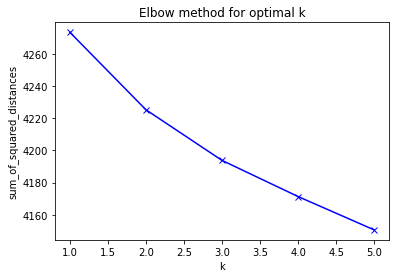

In [26]:
#Find optimum-k
K_top=5 #max number in range

sum_of_squared_distances = []

K = range(1,K_top+1)
for k in K:
    k_means = KMeans(n_clusters=k)
    model = k_means.fit(df_for_clustering)
    sum_of_squared_distances.append(k_means.inertia_)
    print('Modeling with k-means: {} is finish...'.format(k))
    
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow method for optimal k')
plt.show()

In [27]:
#To evaluate the plot, we understood that optimum-k should be;
optimum_k=3

In [28]:
#define the object
k_means = KMeans(n_clusters=optimum_k)

#Run the clustering algorithm
model = k_means.fit(df_for_clustering)

#Generate cluster predictions and store in y_hat
y_hat = k_means.predict(X)
y_hat

array([2, 1, 1, ..., 2, 2, 2])

__Save The Date__

In [43]:
labels=list(y_hat)
df_sum2['Label']=labels #define label column (feature)
df_sum2['Year']=df_sum['Year']
df_sum2.to_csv('data/df_sum_clustering.csv',sep=';')
for n in range(optimum_k):
    print('Topic {}: Total research paper is {}'.format(n, df_sum2[df_sum2['Label']==n].shape[0]))
df_sum2.head(2)

Topic 0: Total research paper is 1714
Topic 1: Total research paper is 593
Topic 2: Total research paper is 2246


,AwardID,AwardTitle,Abstract,Abstract_Tokens,Tokens_String,Top_Word,Top_Word_Freq,Label,Year
0,110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru...",investigator conduct experiment focus crucial ...,restorative,0.608327,2,2001
1,112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong specia...,assurance,0.355567,1,2001


__Create and Save New DataFrame with Topic Words__

In [33]:
df_cluster_words = pd.DataFrame(columns=['TopicWords','TopicWord','TopicTitle','TopicAbstract'], index=range(optimum_k))
for n in range(optimum_k):
    df_cluster_words.loc[n].TopicWords=list(df_sum2[df_sum2['Label']==n]['Top_Word'])
    df_cluster_words.loc[n].TopicWord=list(set(df_sum2[(df_sum2['Label']==n)&(df_sum2['Top_Word_Freq']>0.75)]['Top_Word'].values))
    df_cluster_words.loc[n].TopicTitle=df_sum2[df_sum2['Label']==n].sort_values(by='Top_Word_Freq',ascending=False)[:1]['AwardTitle'].values
    df_cluster_words.loc[n].TopicAbstract=df_sum2[df_sum2['Label']==n].sort_values(by='Top_Word_Freq',ascending=False)[:1]['Abstract'].values
df_cluster_words.to_csv('data/df_cluster_words.csv',sep=';')
df_cluster_words

,TopicWords,TopicWord,TopicTitle,TopicAbstract
0,"[arkansas, cataclysm, geoscience, geoscience, ...","[combustion, indigenous, prp, artist, jurisdic...",[COLLABORATIVE RESEARCH: Development of Inform...,[0412859KumarThis proposal will advance integr...
1,"[assurance, assurance, externship, program, ex...","[forensics, creat]","[""Gamified"" Digital Forensics Course Modules f...",[Cybersecurity and forensics are critical area...
2,"[restorative, packet, chaotic, algebra, sensor...","[textbook, clock, cellulose, agitation, emotio...",[EXP: Attention-Aware Cyberlearning to Detect ...,[The ability to concentrate on tasks is critic...


__Plotting Word Cloud for Clustering__

Topic 0: Total research paper is 1714
Topic 1: Total research paper is 593
Topic 2: Total research paper is 2246


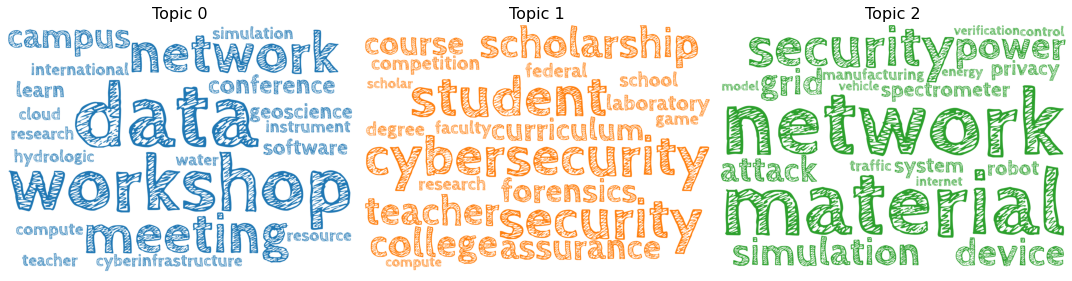

In [34]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

cloud = WordCloud(
                  background_color='white',
                  font_path='font/CabinSketch-Bold.ttf', #we copied spesific font to the folder
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

fig, axes = plt.subplots(1, 3, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = ', '.join(list(dict(nltk.FreqDist(df_cluster_words['TopicWords'][i]).most_common(20))))
    cloud.generate(topic_words)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
    print('Topic {}: Total research paper is {}'.format(i, df_sum2[df_sum2['Label']==i].shape[0]))

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.savefig('plot/NSF_cyber_clustering.png')
plt.show()

### B-) Word Frequency

__Reload The Data__

In [3]:
df_sum2=pd.read_csv('data/df_sum_clustering.csv', sep=';').drop(['Unnamed: 0'],axis=1)
df_sum2.head(2)

,AwardID,AwardTitle,Abstract,Abstract_Tokens,Tokens_String,Top_Word,Top_Word_Freq,Label,Year
0,110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"['investigator', 'conduct', 'experiment', 'foc...",investigator conduct experiment focus crucial ...,restorative,0.608327,2,2001
1,112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"['produce', 'cadre', 'computer', 'scientist', ...",produce cadre computer scientist strong specia...,assurance,0.355567,1,2001


__Change the Tokens Type as 'list'__

In [4]:
df_sum2['Abstract_Tokens']=df_sum2['Abstract_Tokens'].str.replace("'","") #Remove the quotes
df_sum2['Abstract_Tokens'] = df_sum2['Abstract_Tokens'].apply(lambda x: x[1:-1].split(', ')) #Convert string to list
df_sum2.head(2)

,AwardID,AwardTitle,Abstract,Abstract_Tokens,Tokens_String,Top_Word,Top_Word_Freq,Label,Year
0,110599,Collaborative Research Testing Affect Control ...,The investigators will conduct a of experiment...,"[investigator, conduct, experiment, focus, cru...",investigator conduct experiment focus crucial ...,restorative,0.608327,2,2001
1,112426,Federal Cyber Service Initiative,This program produces a cadre of computer scie...,"[produce, cadre, computer, scientist, strong, ...",produce cadre computer scientist strong specia...,assurance,0.355567,1,2001


In [5]:
abstract_keyword_list=[]
for n in range(df_sum2.shape[0]):
    abstract_keyword_list.extend(df_sum2['Abstract_Tokens'][n])
print('Total words in abstract: {}'.format(len(abstract_keyword_list)))

Total words in abstract: 811985


__Counting The Words Frequency__

Pay attention!!! The total number of unique words in the abstract should be equal the 'tf-idf vectorize' columns number. Because both of them use the same counting method.

In [6]:
# Words Frequency
abstract_freq_dict=nltk.FreqDist(abstract_keyword_list)
print('Total unique words in abstract: {}'.format(len(abstract_freq_dict)))

Total unique words in abstract: 13006


In [7]:
#Frequencies of most common 50 words
print('First 50 frequency words:\n{}'.format(abstract_freq_dict.most_common(50)))

First 50 frequency words:
[('project', 12594), ('research', 11818), ('data', 8990), ('system', 8726), ('student', 7754), ('use', 7377), ('support', 5141), ('science', 5079), ('provide', 4938), ('model', 4699), ('include', 4467), ('community', 4236), ('design', 4194), ('develop', 4193), ('network', 4129), ('learn', 3727), ('impact', 3677), ('development', 3549), ('technology', 3416), ('security', 3350), ('tool', 3313), ('software', 2919), ('engineering', 2887), ('education', 2830), ('information', 2798), ('application', 2701), ('work', 2622), ('researcher', 2563), ('infrastructure', 2514), ('compute', 2478), ('resource', 2471), ('need', 2466), ('cybersecurity', 2443), ('cyberinfrastructure', 2419), ('material', 2368), ('study', 2361), ('scientific', 2347), ('activity', 2331), ('enable', 2325), ('understand', 2317), ('result', 2294), ('award', 2250), ('computational', 2225), ('workshop', 2205), ('control', 2177), ('make', 2173), ('analysis', 2163), ('address', 2141), ('method', 2085), ('

In [8]:
#Frequency of a specific word
print("The frequency of word 'internet' is: {}".format(abstract_freq_dict['internet']))

The frequency of word 'internet' is: 717


In [9]:
#Create FreqDist DataFrame
df_FreqDist=pd.DataFrame({'Words':list(abstract_freq_dict.keys()),'Count':list(abstract_freq_dict.values())})
df_FreqDist.sort_values(by=['Count'],ascending=False,inplace=True)
df_FreqDist.set_index('Words',inplace=True)
df_FreqDist.head(2)

,Count
Words,
project,12594
research,11818


__Create a Dataframe for Bar Chart Race__

We need a new dataframe with the most common 50 words of each year. We use frequency distribution to find the most common words.

In [10]:
#Create index list with most common 50 words of each year
year_first=df_sum2['Year'].min()
year_last=df_sum2['Year'].max()

index_list=[]
for n in range(year_first, year_last+1):
    try:
        index_list.extend(list(dict(nltk.FreqDist(df_sum2[df_sum2['Year']==n]['Abstract_Tokens'].sum()).most_common(50))))
        index_list=list(set(index_list))
    except:
        None
print('Total unique tokens: {}'.format(len(index_list)))

#create column list with data period
columns_list=np.arange(year_first, year_last+1)

#Create empty dataframe with index and column names
df_FreqDist50_yearly=pd.DataFrame(index=index_list, columns=columns_list)

#Calculating the Word Frequency of most common 50 tokens for each year  
for i in range(year_first, year_last+1):
    try:
        tokens_freq_dict=dict(nltk.FreqDist(df_sum2[df_sum2['Year']==i]['Abstract_Tokens'].sum()).most_common())
        for n in index_list:
            if n in tokens_freq_dict:
                df_FreqDist50_yearly.loc[n][i]=tokens_freq_dict[n]
            else:
                df_FreqDist50_yearly.loc[n][i]=0
    except:
        df_FreqDist50_yearly[i]=df_FreqDist50_yearly[i-1] #clone the previous year value if there is no article on that year
        
df_FreqDist50_yearly.sort_values(by=year_first, ascending=False, inplace=True) #sort the index by the first column

df_FreqDist50_yearly.head(2)

Total unique tokens: 507


,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
system,5,2,3,4,4,1,1,1,1,1,...,349,436,519,598,949,769,967,776,779,435
robot,4,0,0,0,0,5,0,0,0,0,...,7,5,26,14,43,12,36,33,25,19


__Save The Results__

In [12]:
df_FreqDist.to_csv('data/FreqDist.csv', sep=';')
df_FreqDist50_yearly.to_csv('data/FreqDist50_yearly.csv', sep=';')
df_sum2.to_csv('data/df_sum_clustering.csv',sep=';')
print('Word Frequency Dataframe was saved with {} rows and {} columns'.format(df_FreqDist.shape[0],df_FreqDist.shape[1]))
print('Word Frequency Dataframe/Yearly was saved with {} rows and {} columns'.format(df_FreqDist50_yearly.shape[0],
                                                                                    df_FreqDist50_yearly.shape[1]))

Word Frequency Dataframe was saved with 13006 rows and 1 columns
Word Frequency Dataframe/Yearly was saved with 507 rows and 36 columns


### C-) Terms Analyse

__Reload The Data__

In [44]:
df_FreqDist= pd.read_csv('data/FreqDist.csv', sep=';', index_col='Words')

__Enhance The Frequency Distribution DataFrame by Yearly__

In [45]:
#Add year columns to exists dataframe
columns_list=np.arange(year_first, year_last+1)
df_FreqDist = df_FreqDist.join(pd.DataFrame(
    0, 
    index=df_FreqDist.index, 
    columns=list(columns_list)
))

#Add FreqDist values to every years columns
for i in range(year_first, year_last+1):
    try:
        tokens_freq_dict=dict(nltk.FreqDist(df_sum2[df_sum2['Year']==i]['Abstract_Tokens'].sum()))
        for n in df_FreqDist.index:
            if n in tokens_freq_dict:
                df_FreqDist[i][n]=tokens_freq_dict[n]
    except:
        None
df_FreqDist

,Count,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Words,,,,,,,,,,,,,,,,,,,,,
project,12594,1,1,1,0,0,1,0,2,0,...,582,609,768,861,1171,1091,1255,1286,1356,688
research,11818,2,0,0,5,0,2,0,1,0,...,577,684,751,777,972,1205,986,929,935,563
data,8990,0,4,1,1,0,0,2,1,0,...,272,458,650,645,708,926,1115,951,906,430
system,8726,5,2,3,4,0,1,1,1,0,...,349,436,519,598,949,769,967,776,779,435
student,7754,1,1,2,1,0,1,0,0,0,...,443,465,490,485,632,729,683,727,679,341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
luggage,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
obeys,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
julie,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


__Create 3 New Columns for this DataFrame__

In [152]:
df_FreqDist['UpToLast10Year']=df_FreqDist.iloc[:,1:27].sum(axis=1) #1985-2010
df_FreqDist['Last10Year']=df_FreqDist.iloc[:,27:37].sum(axis=1) #2011-2020
df_FreqDist.loc[df_FreqDist['UpToLast10Year']==0,'UpToLast10Year']=1 #Change 0 to 1 to complete math operations
df_FreqDist['Ratio']=df_FreqDist['Last10Year']/df_FreqDist['UpToLast10Year'].round(decimals=2)
df_FreqDist

,Count,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2014,2015,2016,2017,2018,2019,2020,UpToLast10Year,Last10Year,Ratio
Words,,,,,,,,,,,,,,,,,,,,,
project,12594,1,1,1,0,0,1,0,2,0,...,861,1171,1091,1255,1286,1356,688,2927,9667,3.302699
research,11818,2,0,0,5,0,2,0,1,0,...,777,972,1205,986,929,935,563,3439,8379,2.436464
data,8990,0,4,1,1,0,0,2,1,0,...,645,708,926,1115,951,906,430,1929,7061,3.660446
system,8726,5,2,3,4,0,1,1,1,0,...,598,949,769,967,776,779,435,2149,6577,3.060493
student,7754,1,1,2,1,0,1,0,0,0,...,485,632,729,683,727,679,341,2080,5674,2.727885
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
luggage,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,1,1.000000
obeys,1,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1,1.000000
julie,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.000000


In [162]:
df_FreqDist[(df_FreqDist['UpToLast10Year']>10)&(df_FreqDist['Last10Year']<10)].index

Index(['reinvestment', 'mu', 'spectrometry', 'renovation', 'multiuser',
       'renovate', 'berkeley', 'broadcast', 'illinois', 'openness', 'park',
       'mobilize', 'foreign', 'asia', 'shear', 'hydrogen', 'crystalline',
       'voting', 'deaf', 'india', 'hill', 'oak', 'bullying', 'anisotropic',
       'anthropogenic', 'activation', 'kinetics', 'buffalo', 'unusual',
       'cybernetics', 'biologically', 'deliberate', 'bonding', 'tectonics',
       'workstation', 'bay', 'polymeric', 'invention', 'nucleation', 'bot',
       'electronically', 'ionization', 'dissection', 'municipal', 'worm',
       'sport', 'aggressive', 'david', 'gold', 'usefulness', 'fracture',
       'pueblo', 'anatomy', 'downstream', 'conclude', 'organometallic',
       'mantle', 'receptor', 'tg', 'linguist', 'survivable', 'conformation',
       'biaxial', 'pond', 'crystallization', 'pop', 'australia', 'sweet', 'fy',
       'lc', 'paleomagnetic', 'ostracism', 'geon', 'referral'],
      dtype='object', name='Words')

__Compare the Words of the Last 10 Years and Before__

In [177]:
#The words which are used commonly until the last 10 years in papers
notused_last10years=df_FreqDist[(df_FreqDist['UpToLast10Year']>10)&(df_FreqDist['Last10Year']<10)].index
print("Total {} words are used commonly until the last 10 years.\nFor example:\n{}".format(len(notused_last10years), 
                                                                                     list(notused_last10years[:5])))

Total 74 words are used commonly until the last 10 years.
For example:
['reinvestment', 'mu', 'spectrometry', 'renovation', 'multiuser']


In [178]:
#The words which are used commonly last 10 years in papers
used_last10years=df_FreqDist[(df_FreqDist['UpToLast10Year']<10)&(df_FreqDist['Last10Year']>10)].index
print("Total {} words are used commonly last 10 years.\nFor example:\n{}".format(len(used_last10years), 
                                                                                     list(used_last10years[:5])))

Total 1406 words are used commonly last 10 years.
For example:
['deem', 'worthy', 'statutory', 'resilience', 'resilient']


In [225]:
#First Used
df_FreqDist['FirstUsed']=0
for n in range(1,df_FreqDist.shape[0]+1):
    column_index=(df_FreqDist.iloc[n-1:n,1:-3].values !=0).argmax()
    column_name=df_FreqDist.columns[1+column_index]
    df_FreqDist['FirstUsed'][n-1]=column_name
df_FreqDist

,Count,1985,1986,1987,1988,1989,1990,1991,1992,1993,...,2015,2016,2017,2018,2019,2020,UpToLast10Year,Last10Year,Ratio,FirstUsed
Words,,,,,,,,,,,,,,,,,,,,,
project,12594,1,1,1,0,0,1,0,2,0,...,1171,1091,1255,1286,1356,688,2927,9667,3.302699,1985
research,11818,2,0,0,5,0,2,0,1,0,...,972,1205,986,929,935,563,3439,8379,2.436464,1985
data,8990,0,4,1,1,0,0,2,1,0,...,708,926,1115,951,906,430,1929,7061,3.660446,1986
system,8726,5,2,3,4,0,1,1,1,0,...,949,769,967,776,779,435,2149,6577,3.060493,1985
student,7754,1,1,2,1,0,1,0,0,0,...,632,729,683,727,679,341,2080,5674,2.727885,1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
luggage,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,1.000000,2014
obeys,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,1,1.000000,2015
julie,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0.000000,2008


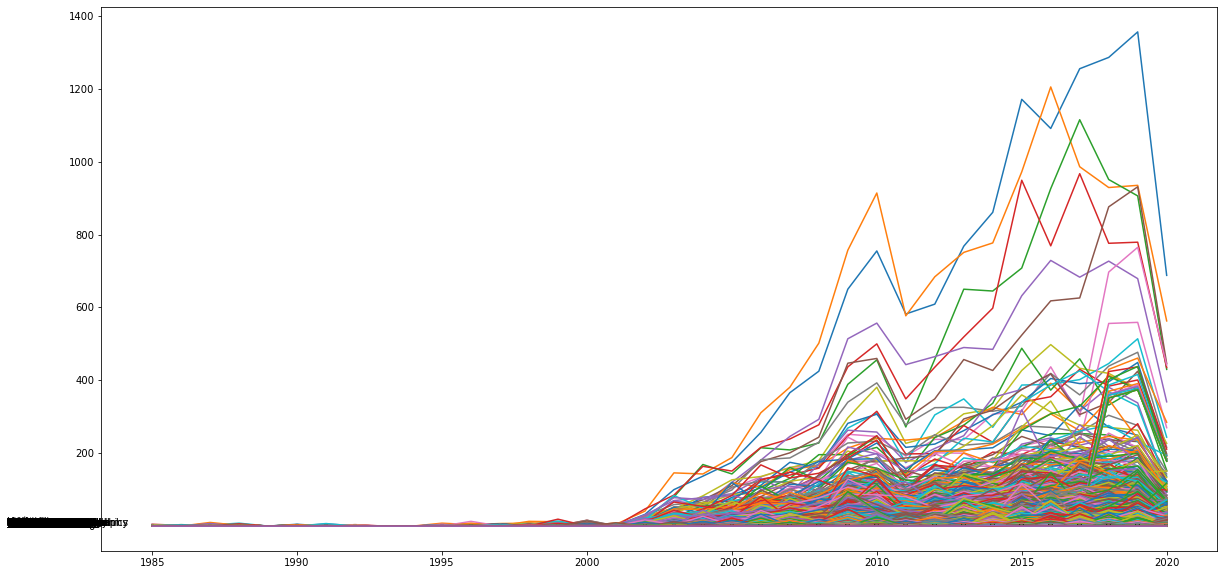

In [224]:
fig = plt.figure(figsize=(20,10))
for n in range(1,df_FreqDist.shape[0]+1):
    plt.plot(np.arange(1985,2021),df_FreqDist.iloc[n-1:n,1:37].values[0])
    plt.text(1980, df_FreqDist.iloc[n-1:n,1:37].values[0][0],df_FreqDist.iloc[n-1:n,:].index[0] )
plt.show()

__Save The Results__

In [ ]:
df_FreqDist.to_csv('data/FreqDist.csv', sep=';')